# GP 教程-E02: 一小时上手的简单GP
作者: Wei W. Xing (wxing.me) <br />
翻译: Yuxin Wang
日期: 2022-03-28    <br />

摘要: 现如今高斯过程已经是一个长期存在并且广泛被应用的技术，并且也有很多有用的教程、课本、文章以及博客，但是我发现很多学生（包括学生时代的我）都曾经在将GP应用到实际问题这个过程中碰壁。我认为学会一个东西最简单的方法就是应用它而不是准备很多必要的数学背景或者深入理论。因此我准写了这篇教程，希望可以用一种比较直接的方式来应用GP这个技术，尤其是为了工科的学生们。希望这篇教程能有所帮助。

在这篇教程中，我们希望可以考虑最简单的一维输出的例子，也就是，$y \in \mathcal{R}^1$，是一维标量。相对应的
$\mathcal{x} \in \mathcal{R}^D$，输入的是一个D维的向量。
那么让我们开始吧～ 由于这篇应用是基于Torch开发的，所以我们将从导入Torch库作为开端。

In [23]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import os
# from torch.autograd import Variable

print(torch.__version__)
# I use torch (1.11.0) for this work. lower version may not work.

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS 

JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

1.10.2


#### 1. 生成综合数据
将$y = (6x-2)^2sin(12x-4)$作为我们的目标拟合函数。我们将需要产生包含32组样本点的训练数据集$xtr, ytr$ 以及包含100组数据的测试数据集$xte, yte$ 。

xtr.size: torch.Size([32, 1]) ytr.size: torch.Size([32, 1])
xte.size: torch.Size([100, 1]) yte.size: torch.Size([100, 1])


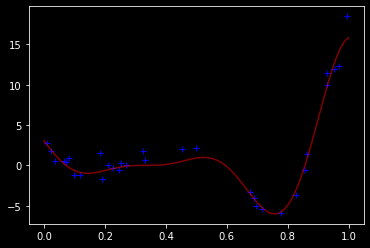

In [24]:
#train_set
xtr = torch.rand(32, 1)
ytr = ((6*xtr - 2)**2) * torch.sin(12*xtr - 4) + torch.randn(32, 1) * 1

#test_set
xte = torch.linspace(0, 1, 100).view(-1,1)
yte = ((6*xte - 2)**2) * torch.sin(12*xte - 4)

#plot the data
print("xtr.size:", xtr.size(), "ytr.size:", ytr.size())
print("xte.size:", xte.size(), "yte.size:", yte.size())
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.plot(xte.numpy(), yte.numpy(), 'r-', alpha = 0.5)
plt.show()

#### 2. 核函数以及模型参数（超参数）

我们需要优化的函数是：均值函数以及核函数。但是优化一个“函数”并不是就想所说的那么简单， 因此我们需要给丁这些函数的特定形式，之后再去优化他们的参数。在这篇教程中，我们设定均值函数为零（不需要优化均值函数）。而核函数部分，我们使用最常用的automatic relevance determinant（ARD）核函数：
$$k_{ard}(\mathbf{x}, \mathbf{x}') = a \cdot \exp(-\frac{1}{2} \sum_{d=1}^D{ (\frac{x_d-x'_d}{l_d}})^2 )$$
其中$a$是核函数的振幅，$l_d$是输入变量$x$的d维输入${x}_d$的长度系数（length scale）。$\mathbf{l}$ 控制着每个输入维度的贡献量，比如：$l_d$数值越大，则${x}_d$相比于其他维度在系统中的贡献越大；反之亦然。因此，这个函数被称为ARD，即可以自动控制相关性。 <br />

在开始编程之前还有另一件事情需要注意，$l_d$和$a$均为正参数。所以如果我们直接将他们定义为torch中的参数torch.parameters，则在优化过程中有可能导致$l_d$和$a$被计算成负数。因此我们需要特别注意确保$l_d$和$a$在过程中为正数。一个简单的方法就是，用他们取log之后的值来定义，而使用的时候再将其转换为其指数值。 <br />

 那么现在我们可以定义核函数了，其返回值为输入两组数据的一个核矩阵。

In [25]:
# define kernel parameters
log_length_scale = nn.Parameter(torch.zeros(xte.size(1)))
log_scale = nn.Parameter(torch.zeros(1))


In [26]:
def kernel(X1, X2, log_length_scale, log_scale): 
    length_scale = torch.exp(log_length_scale)
    K = torch.zeros(X1.size(0), X2.size(0))
    
    for i in range(X1.size(0)):
        for j in range(X2.size(0)):
            for d in range(X1.size(1)):
                K[i,j] = torch.exp(-0.5 * ((X1[i,d] - X2[j,d])**2 / length_scale[d]**2).sum() ) * torch.exp(log_scale)
    return K

K1 = kernel(xtr, xtr, log_length_scale, log_scale)
print(K1)

tensor([[1.0000, 0.8717, 0.7607,  ..., 0.9929, 0.7489, 0.9879],
        [0.8717, 1.0000, 0.9770,  ..., 0.8128, 0.9725, 0.7935],
        [0.7607, 0.9770, 1.0000,  ..., 0.6913, 0.9998, 0.6696],
        ...,
        [0.9929, 0.8128, 0.6913,  ..., 1.0000, 0.6789, 0.9993],
        [0.7489, 0.9725, 0.9998,  ..., 0.6789, 1.0000, 0.6571],
        [0.9879, 0.7935, 0.6696,  ..., 0.9993, 0.6571, 1.0000]],
       grad_fn=<CopySlices>)


然而，在编程过程中我们应该尽可能的避免使用循环结构，这是以内循环会导致消耗大量的内存以及时间。因此我们将用另一种方法来撰写核函数。

In [27]:
def kernel(X1, X2, log_length_scale, log_scale): # 定义核函数没有加linear

    X1 = X1 / log_length_scale.exp()
    X2 = X2 / log_length_scale.exp()

    X1_norm2 = X1 * X1
    X2_norm2 = X2 * X2

    K = -2.0 * X1 @ X2.t() + X1_norm2.expand(X1.size(0), X2.size(0)) + X2_norm2.t().expand(X1.size(0), X2.size(0))  #this is the effective Euclidean distance matrix between X1 and X2.
    K = log_scale.exp() * torch.exp(-0.5 * K)
    return K

K2 = kernel(xtr, xtr, log_length_scale, log_scale)
print(K2)
print( (K1 - K2).norm() )

tensor([[1.0000, 0.8717, 0.7607,  ..., 0.9929, 0.7489, 0.9879],
        [0.8717, 1.0000, 0.9770,  ..., 0.8128, 0.9725, 0.7935],
        [0.7607, 0.9770, 1.0000,  ..., 0.6913, 0.9998, 0.6696],
        ...,
        [0.9929, 0.8128, 0.6913,  ..., 1.0000, 0.6789, 0.9993],
        [0.7489, 0.9725, 0.9998,  ..., 0.6789, 1.0000, 0.6571],
        [0.9879, 0.7935, 0.6696,  ..., 0.9993, 0.6571, 1.0000]],
       grad_fn=<MulBackward0>)
tensor(5.7171e-07, grad_fn=<CopyBackwards>)


我们可以看到两个核函数的结果是相通的，然而执行的时间却又很大的不同，我们还可以将训练数据的样本量增大来验证这种差异。    <br />

此外，我们还需要定义GP中的噪声$\sigma^2$。为了能够更简单地在今后的教程中介绍共轭先验只是，我们选择使用$\sigma^2$的逆$\beta=1/\sigma^2$来定义噪声，而不是直接定义$\sigma^2$，并且与长度系数核振幅相同，我们也需要确保噪声的值恒为正数。

In [28]:
log_beta = nn.Parameter(torch.ones(1) * -4) # this is a large noise. we optimize to shrink it to a proper value. 

#### 3. 似然函数的负对数（negative log likelihood）
对于大部分回归问题，我们需要对已定义好的损失函数求最小值。那么在GP中，损失函数就是似然函数值的负对数。

因为我们需要对损失函数最小化，所以我们选择将似然函数取对数后再取相反数，并且由于似然函数值的对数有更为清晰的形式，并且不改变函数的单调性，所以对似然函数值取对数。

似然函数的负对数形式为：
$$L=-\frac{1}{2}\mathbf{y}^T (\mathbf{K}+\sigma^2 \mathbf{I})^{-1}\mathbf{y}-\frac{1}{2}\log(|\mathbf{K}+\sigma^2 \mathbf{I}|)-\frac{n}{2}log(2\pi)$$
其中$\mathbf{y}$是将观测数据按照$N\times1$向量形式排列，$\mathbf{K}$是训练数据的大小为N\times N$的核矩阵。$\sigma^2$是噪声方差，并且$\mathbf{I}$是单位矩阵。

接下来我们用$\mathbf{\Sigma}=\mathbf{K}+\sigma^2 \mathbf{I}$来代替核矩阵的逆，则损失函数可以写为：
$$nll=\frac{1}{2}\mathbf{y}^T\mathbf{\Sigma}^{-1}\mathbf{y}+\frac{1}{2}\log(|\mathbf{\Sigma}|)+\frac{n}{2}log(2\pi)$$

我们虽然可以利用以后的损失函数值直接进行计算以及优化，但是由于求维度较高的矩阵的逆同样会十分占用时间与内存，因此，我们应该避免这种计算，而此采用另一个技巧（Cholesky 分解）来更佳高效稳定的计算。

首先，计算核矩阵的cholesky分解：
$\mathbf{\Sigma} = \mathbf{L} \mathbf{L}^T$
所以在似然函数的负对数表达式中的第一项，可以推导为：
$$ \mathbf{y}^T (\mathbf{K}+\sigma^2 \mathbf{I})^{-1}\mathbf{y} = \mathbf{y}^T (\mathbf{L} \mathbf{L}^T)^{-1} \mathbf{y} = \mathbf{y}^T \mathbf{L}^{-T} \mathbf{L}^{-1} \mathbf{y}  = (\mathbf{L}^{-1} \mathbf{y})^T \mathbf{L}^{-1} \mathbf{y}  $$
这个公式让我们通过解一个线性方程组的方式，$\mathbf{L} \mathbf{\gamma} = \mathbf{y}$，避免了矩阵求逆所带来的资源的浪费，并且给出了$\mathbf{L}^{-1} \mathbf{y} = \mathbf{\gamma}$。所以如果我们获得了$\mathbf{\gamma}$，我们就能够计算表达式中的第一项，也就是$\mathbf{\gamma}$的二范数。

之后我们可以计算损失函数表达式中的第二项，即
$$ \log(|\mathbf{\Sigma}|) = \log(| \mathbf{L} \mathbf{L}^T |) =  \log(|\mathbf{L}| |\mathbf{L}^T|) = \log(\prod_{i=1}^{N} L_{ii} \prod_{i=1}^{N} L_{ii}) = 2\sum_{i=1}^{N}\log(L_{ii})$$

在经过了以上两个部分之后，损失函数可以表达为：
$$nll=\frac{1}{2} \mathbf{\gamma}^T \mathbf{\gamma} + \sum_{i=1}^{N}\log(L_{ii}) + \frac{n}{2}log(2\pi)$$

那么接下来，我们一起将这个过程用代码表达出来。

In [29]:
def negative_log_likelihood(X, Y, log_length_scale, log_scale, log_beta):
    y_num = Y.size(0)
    Sigma = kernel(X, X, log_length_scale, log_scale) + log_beta.exp().pow(-1) * torch.eye(X.size(0)) + JITTER * torch.eye(X.size(0))   # add JITTER here to avoid singularity
    
    L = torch.linalg.cholesky(Sigma)
    #option 1 (use this if torch supports)
    gamma,_ = torch.triangular_solve(Y, L, upper = False)
    # print(gamma.shape)
    # print("gamma **2:")
    # print((gamma**2).sum())
    # print("gamma.T@gamma")
    # print(gamma.T@gamma)
    #option 2
    # gamma = L.inverse() @ Y       # we can use this as an alternative because L is a lower triangular matrix.
    
    nll =  0.5 * (gamma ** 2).sum() +  L.diag().log().sum()  + 0.5 * y_num * torch.log(2 * torch.tensor(PI))
    return nll

补充：(by zhenjie)<br/>
gamma,_ = torch.triangular_solve(Y, L, upper = False)<br/>
这里使用了torch.triangular_solve 函数，该函数用于解决三角线性系统。具体来说，它解决以下形式的线性系统方程： AX=B<br/>
其中 A 是一个上三角或下三角矩阵（由参数 upper 决定），X 是未知矩阵，B 是已知矩阵。<br/>
在这个代码中，Y 是已知矩阵，L 是下三角矩阵，gamma 是解矩阵<br/>
具体而言，torch.triangular_solve(Y, L, upper=False) 的调用是将 Y 视为右侧矩阵，L 视为下三角矩阵，通过解决 LX=Y 来计算解矩阵 gamma。<br/>
gamma 将是解矩阵，满足 L ⋅ gamma = Y。

#### 4. 调用优化器
当损失函数，也就是似然函数的负对数定义好之后，我们可以很简单地通过调用优化器来最小化损失函数值。

In [30]:
def train_adam(X, Y, log_length_scale, log_scale, log_beta, niter = 50, lr = 0.001):
    optimizer = torch.optim.Adam([log_beta, log_length_scale, log_scale], lr = lr)
    optimizer.zero_grad()
    for i in range(niter):
        optimizer.zero_grad()
        # self.update()
        loss = negative_log_likelihood(X, Y, log_length_scale, log_scale, log_beta)
        loss.backward()
        optimizer.step()

        # print the nll
        # print('iter', i, ' nnl:', loss.item())
        print('iter', i, 'nnl:{:.5f}'.format(loss.item()))
        # print the likelihood
        # print('iter', i, 'nnl:{:.5f}'.format(loss.item()),'likelihood:{:.9f}'.format((-loss).exp().item()) )
        
train_adam(xtr, ytr,log_length_scale, log_scale, log_beta, 5, 0.01)

iter 0 nnl:102.83882
iter 1 nnl:102.77118
iter 2 nnl:102.70448
iter 3 nnl:102.63876
iter 4 nnl:102.57405


#### 5. 预测 Predictive Prosterior 

当超参数优化完毕之后，我们可以根据如下的公式对预测后验分布进行计算：
\begin{aligned}
&\mu=\mathbf{k}^* \Sigma^{-1} \mathbf{y}\\
&s^2=\mathbf{k}_{**}- (\mathbf{k}^*)^T \mathbf{\Sigma}^{-1} \mathbf{k}^* + {1}/{\beta}\\
\end{aligned}
如上文我们所提到的一样，我们应该尽可能的避免计算矩阵的逆。所以我们将再次次啊用cholesky分解以获得预测后验。

首先我们定义 $\mathbf{\Sigma}^{-1} \mathbf{y} =  \mathbf{\alpha}$，这个方法经常在文献和开放源代码中使用。引入 $\mathbf{\alpha}$ 的优点是：<br />
1）我们可以使用cholesky分解计算预测后验；<br />
2）节省内存并提供更快去的后验预测（不需要计算逆矩阵）<br />
通过使用 $\mathbf{L}$ 以获得 $\mathbf{\alpha}$, 我们首先解决了 $\mathbf{L} \mathbf{\gamma} = \mathbf{y}$，之后在计算 $\mathbf{L}^T \mathbf{y} = \mathbf{\gamma}$, 如你所见，有时会写成一种简洁的形式
$$\mathbf{\alpha} = \mathbf{L}^T \backslash \mathbf{L} \backslash \mathbf{y}$$

$(\mathbf{k}^*)^T \mathbf{\Sigma}^{-1} \mathbf{k}^*$ 的计算则很类似 $\mathbf{\gamma}^T \mathbf{\gamma}$ 在之前提到的计算。

In [31]:
def forward(X, Xte, log_length_scale, log_scale, log_beta, Y):
    n_test = Xte.size(0)
    Sigma = kernel(X, X, log_length_scale, log_scale) + log_beta.exp().pow(-1) * torch.eye(
        X.size(0)) + JITTER * torch.eye(X.size(0))
    kx = kernel(X, Xte, log_length_scale, log_scale)
    L = torch.cholesky(Sigma)
    
    # option 1
    mean = kx.t() @ torch.cholesky_solve(Y, L)  # torch.linalg.cholesky()
    # option 2
    # mean = kx @ torch.L.t().inverse() @ L.inverse() @ Y
    
    # LinvKx = L.inverse() @ kx.t()  # TODO: the inverse for L should be cheap. check this.
        # torch.cholesky_solve(kx.t(), L)
    LinvKx,_ = torch.triangular_solve(kx, L, upper = False)
    # option 1, standard way
    # var_diag = kernel(Xte, Xte, log_length_scale, log_scale).diag().view(-1,1) - (LinvKx.t() @ LinvKx).diag().view(-1, 1)
    # option 2, a faster way
    var_diag = log_scale.exp().expand(n_test, 1) - (LinvKx**2).sum(dim = 0).view(-1, 1)
    
    var_diag = var_diag + log_beta.exp().pow(-1)
    return mean, var_diag

#### 5. 测试与验证
我们将在综合数据集上应用GP模型，并将结果可视化。

iter 0 nnl:102.51033
iter 1 nnl:101.92053
iter 2 nnl:101.42941
iter 3 nnl:101.04358
iter 4 nnl:100.76581
iter 5 nnl:100.59152
iter 6 nnl:100.50455
iter 7 nnl:100.47401
iter 8 nnl:100.45668
iter 9 nnl:100.40707
iter 10 nnl:100.29047
iter 11 nnl:100.08932
iter 12 nnl:99.80045
iter 13 nnl:99.42682
iter 14 nnl:98.96941
iter 15 nnl:98.42157
iter 16 nnl:97.76694
iter 17 nnl:96.98277
iter 18 nnl:96.04974
iter 19 nnl:94.96342
iter 20 nnl:93.73794
iter 21 nnl:92.39982
iter 22 nnl:90.98499
iter 23 nnl:89.54336
iter 24 nnl:88.13529
iter 25 nnl:86.81189
iter 26 nnl:85.59512
iter 27 nnl:84.47242
iter 28 nnl:83.40781
iter 29 nnl:82.35940
iter 30 nnl:81.29222
iter 31 nnl:80.18121
iter 32 nnl:79.00968
iter 33 nnl:77.76864
iter 34 nnl:76.45632
iter 35 nnl:75.07997
iter 36 nnl:73.65873
iter 37 nnl:72.22557
iter 38 nnl:70.82964
iter 39 nnl:69.53761
iter 40 nnl:68.43094
iter 41 nnl:67.58779
iter 42 nnl:67.02991
iter 43 nnl:66.63993
iter 44 nnl:66.20660
iter 45 nnl:65.62907
iter 46 nnl:64.99395
iter 47 nnl

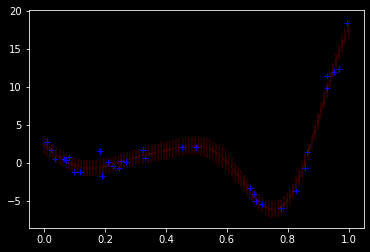

In [32]:
train_adam(xtr, ytr, log_length_scale, log_scale, log_beta, 100, 0.1)
with torch.no_grad():
    ypred, yvar = forward(xtr, xte, log_length_scale, log_scale, log_beta, ytr)
    
plt.errorbar(xte.numpy().reshape(100), ypred.detach().numpy().reshape(100),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.show()